At first I'll import all the needed libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.metrics import r2_score
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score
import operator
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.metrics import plot_confusion_matrix

Ok, now I will load given data. It's csv file, so I use read_csv.

In [2]:
df = pd.read_csv('Dane_bank_nowe.csv', sep=',')

**It is good practice to work on a copy of the data, not on the original file.** If we will edit few times original file and after 3 hours it will turn out that deleting one of the column was a mistake - working on a copy will allow us to quickly restore the column :) So..

In [3]:
df_copy = df.copy(deep = True)

### Let's see what do we have here ;)

In [4]:
df_copy.head()

,Unnamed: 0,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,886607.90,1
1,1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,916554.56,0
2,2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,849781.25,1
3,3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,1367384.50,0
4,4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,1504164.20,0


In [5]:
df_copy.duplicated().sum()

0

Ok, there are no duplicates in this file - that's good information ;)

There are few columns, which are not useful for further analysis:
* Unnamed: 0
* RowNumber
* CustomerId
* Surname (I assumed that surname has no impact had no effect on creditworthiness ;) )

So, goodbye columns!

In [6]:
to_drop = ['RowNumber', 'Surname', 'CustomerId', 'Unnamed: 0'] 
df_copy.drop(to_drop, inplace=True, axis=1)
draft_df = df_copy

Did it work?

In [7]:
draft_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,886607.90,1
1,608,Spain,Female,41,1,83807.86,1,0,1,916554.56,0
2,502,France,Female,42,8,159660.80,3,1,0,849781.25,1
3,699,France,Female,39,1,0.00,2,0,0,1367384.50,0
4,850,Spain,Female,43,2,125510.82,1,1,1,1504164.20,0


Yup, it's ok :)

In next step I'm going to check non-numeric columns and convert data into numeric. It will make work much easier and it's necessary e.g. to make chart.

In [8]:
draft_df.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [9]:
draft_df.Gender.unique()

array(['Female', 'Male'], dtype=object)

In [10]:
d = {'France':1,'Spain':2,'Germany':3, 'Female':0, 'Male':1}
final_df = df_copy.replace(d)

In [11]:
final_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,1,0,42,2,0.00,1,1,1,886607.90,1
1,608,2,0,41,1,83807.86,1,0,1,916554.56,0
2,502,1,0,42,8,159660.80,3,1,0,849781.25,1
3,699,1,0,39,1,0.00,2,0,0,1367384.50,0
4,850,2,0,43,2,125510.82,1,1,1,1504164.20,0


Much better, isn't it?

Ok, now let's see more information about data:

In [12]:
final_df.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.000000
mean,650.528800,1.749500,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,1.130141e+06,0.203700
std,96.653299,0.830433,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,3.078528e+05,0.402769
min,350.000000,1.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.914779e+05,0.000000
25%,584.000000,1.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,8.728450e+05,0.000000
50%,652.000000,1.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,1.160135e+06,0.000000
75%,718.000000,3.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,1.363969e+06,0.000000
max,850.000000,3.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,1.730501e+06,1.000000


### What can we see here? 

I think I don't have to explain what mean or standard deviation is, or how to come to any conclusion looking at these data ;) 

In this step I'm looking for any nonstandard and illogical informations, which would be a message that this data needs more "cleaning". For example:
* **minimal value of age < 18** might be due to mistake. Then, we should check how many positions with age < 18 is in the data. If there are few of them - I would delete them (all rows, not only cells) and it's ok. But it might tourned out that we have 500/10000 positions with age in the range 13-17, because bank has in its offer account for young people. And we have no column, where this information is included. Then we would have to decide what to do with it.
* **has credit card > 1** or **has credit card = 0.6** - we have separate column with number of products, information other than 0 or 1 would be a mistake.
* **max number of products = 1872** - suspicious, right?

In the table above I don't see any illogical data. Let's move on!

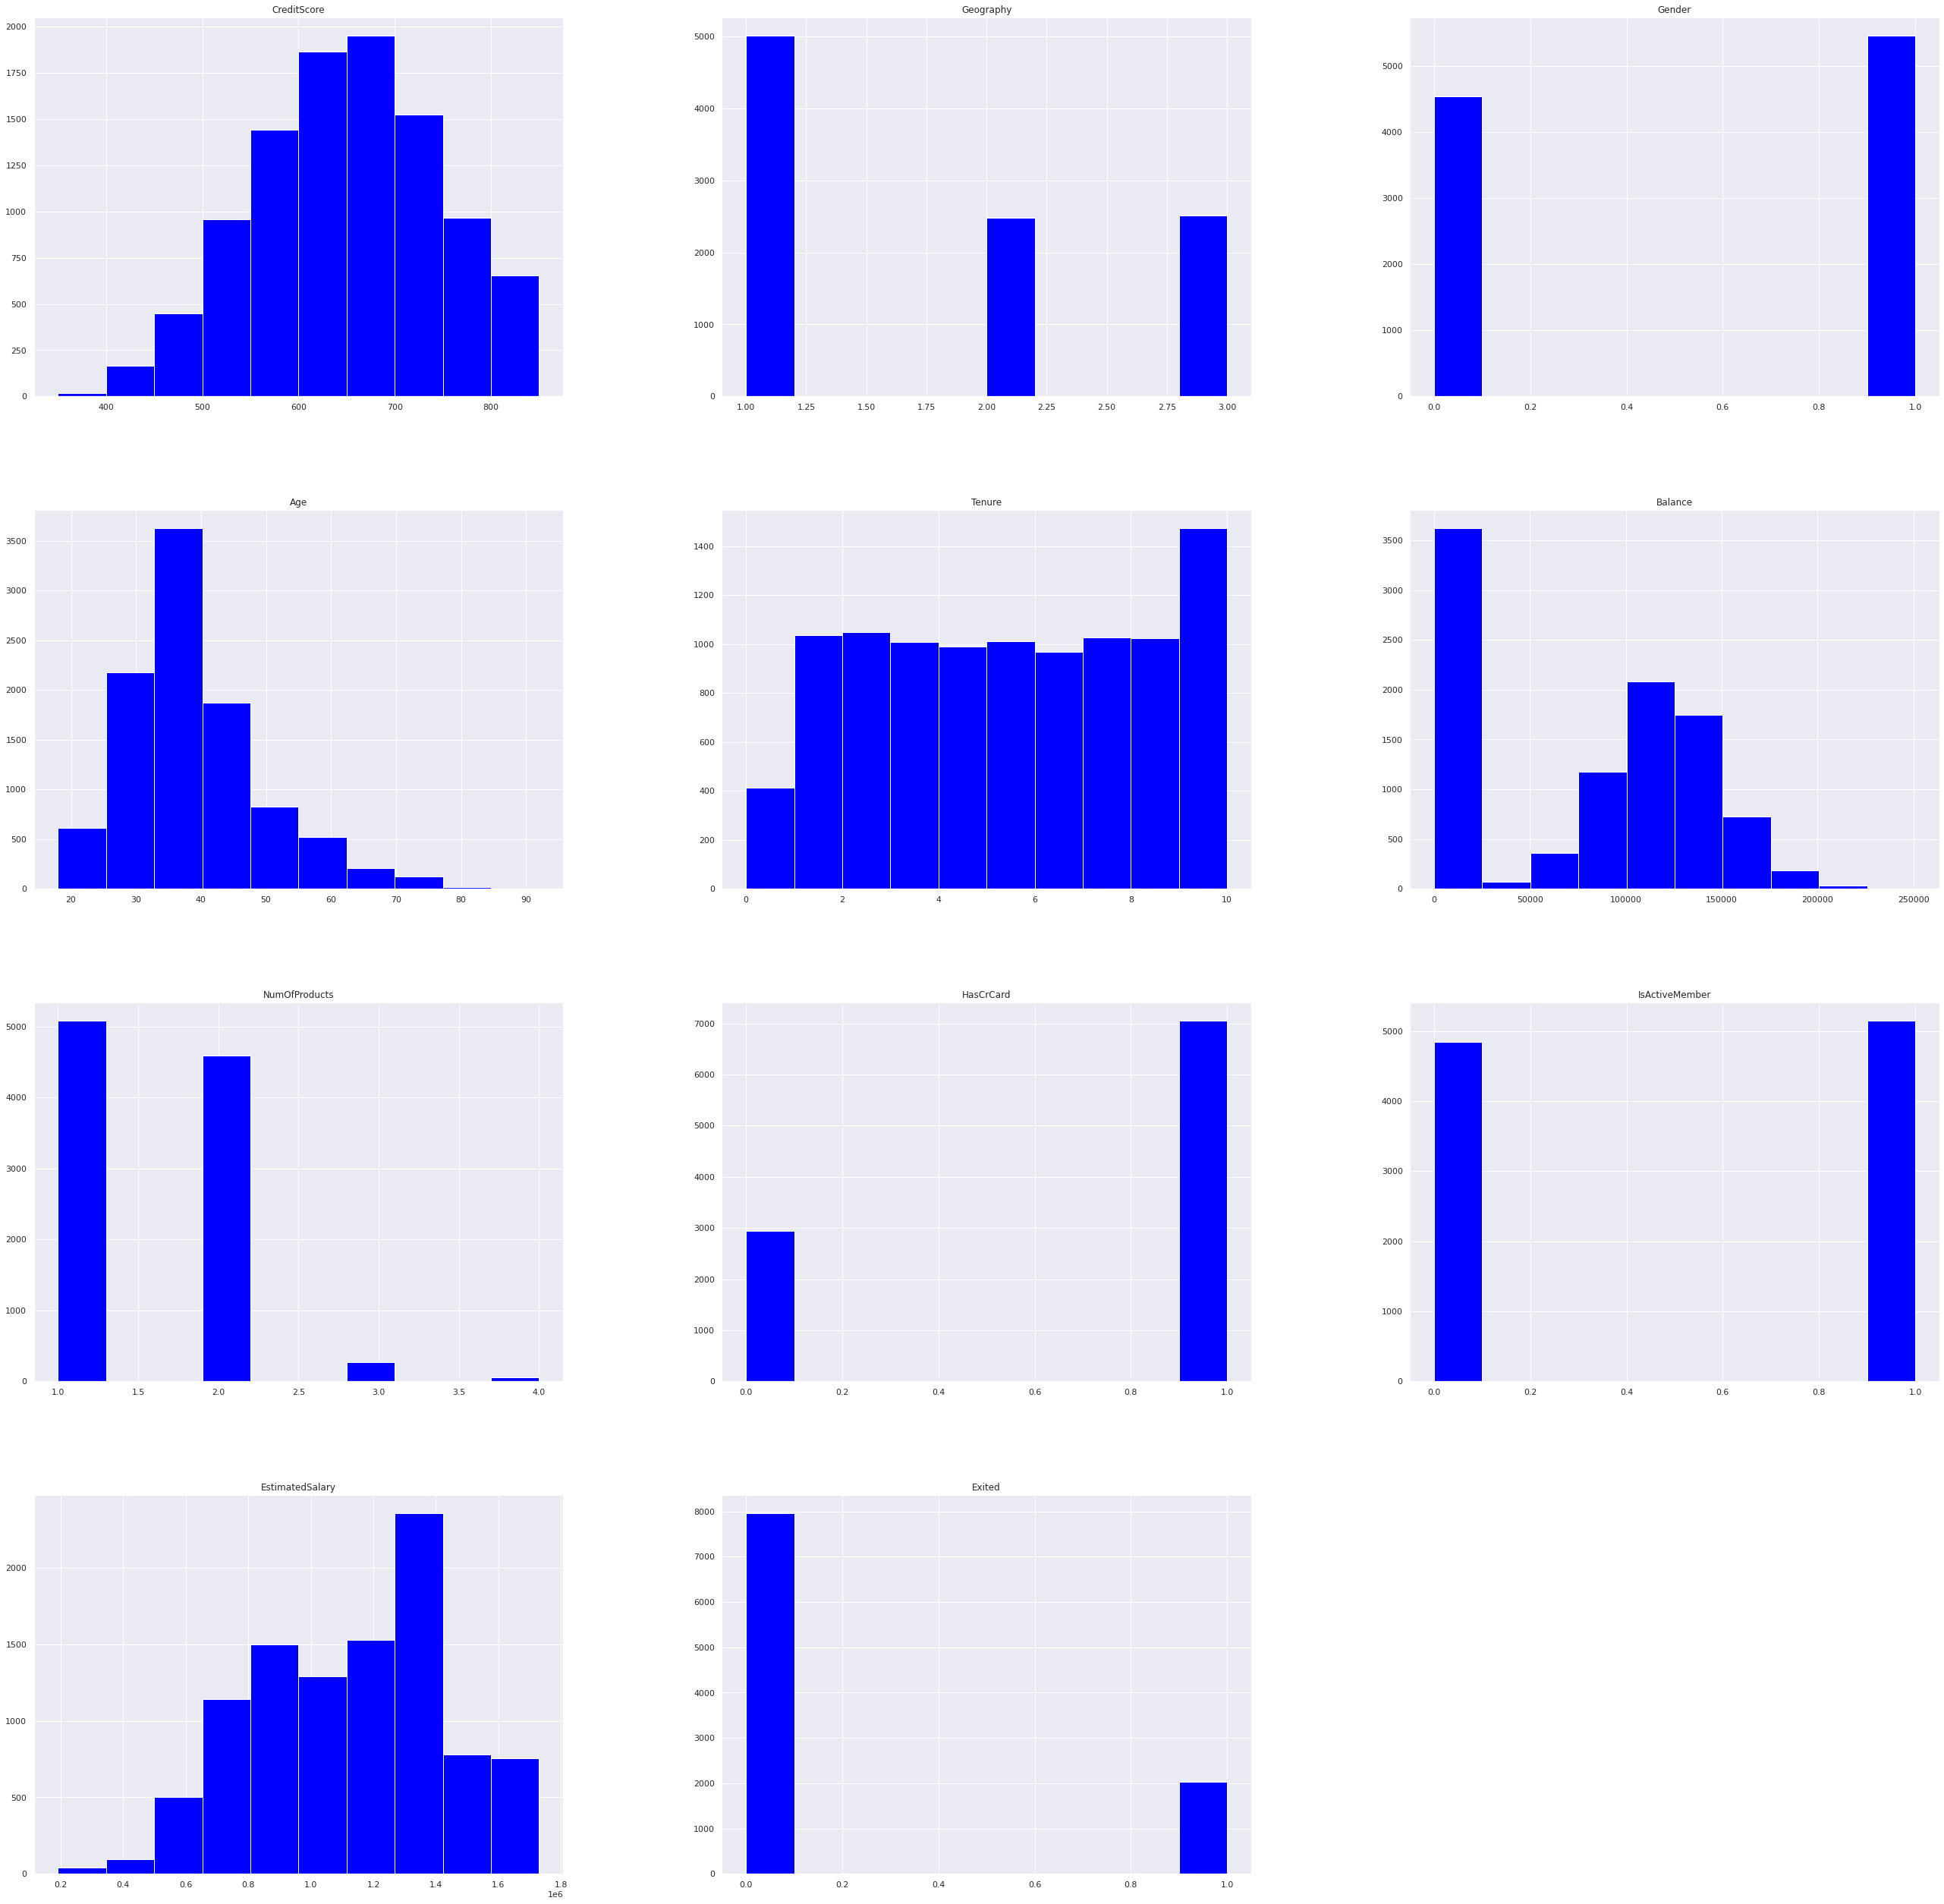

In [13]:
sns.set()
final_df.hist(figsize=(45,45), color='blue')
plt.show()

### Above plots show us some interesting things:

* the majority of clients are in the age group ~33-40
* more than 3600 clients has no money at their account (Balance = 0)
* there are around 20% exited clients
* there are more male than female clients
* almost half of clients come from France
* around 70% of clients has credit card
* roughly the same number of customers use actively the account as not
* the most customers has one product, a bit less has two products - very few customers have 3 or more products

### Now it's time to check how correlation looks like:

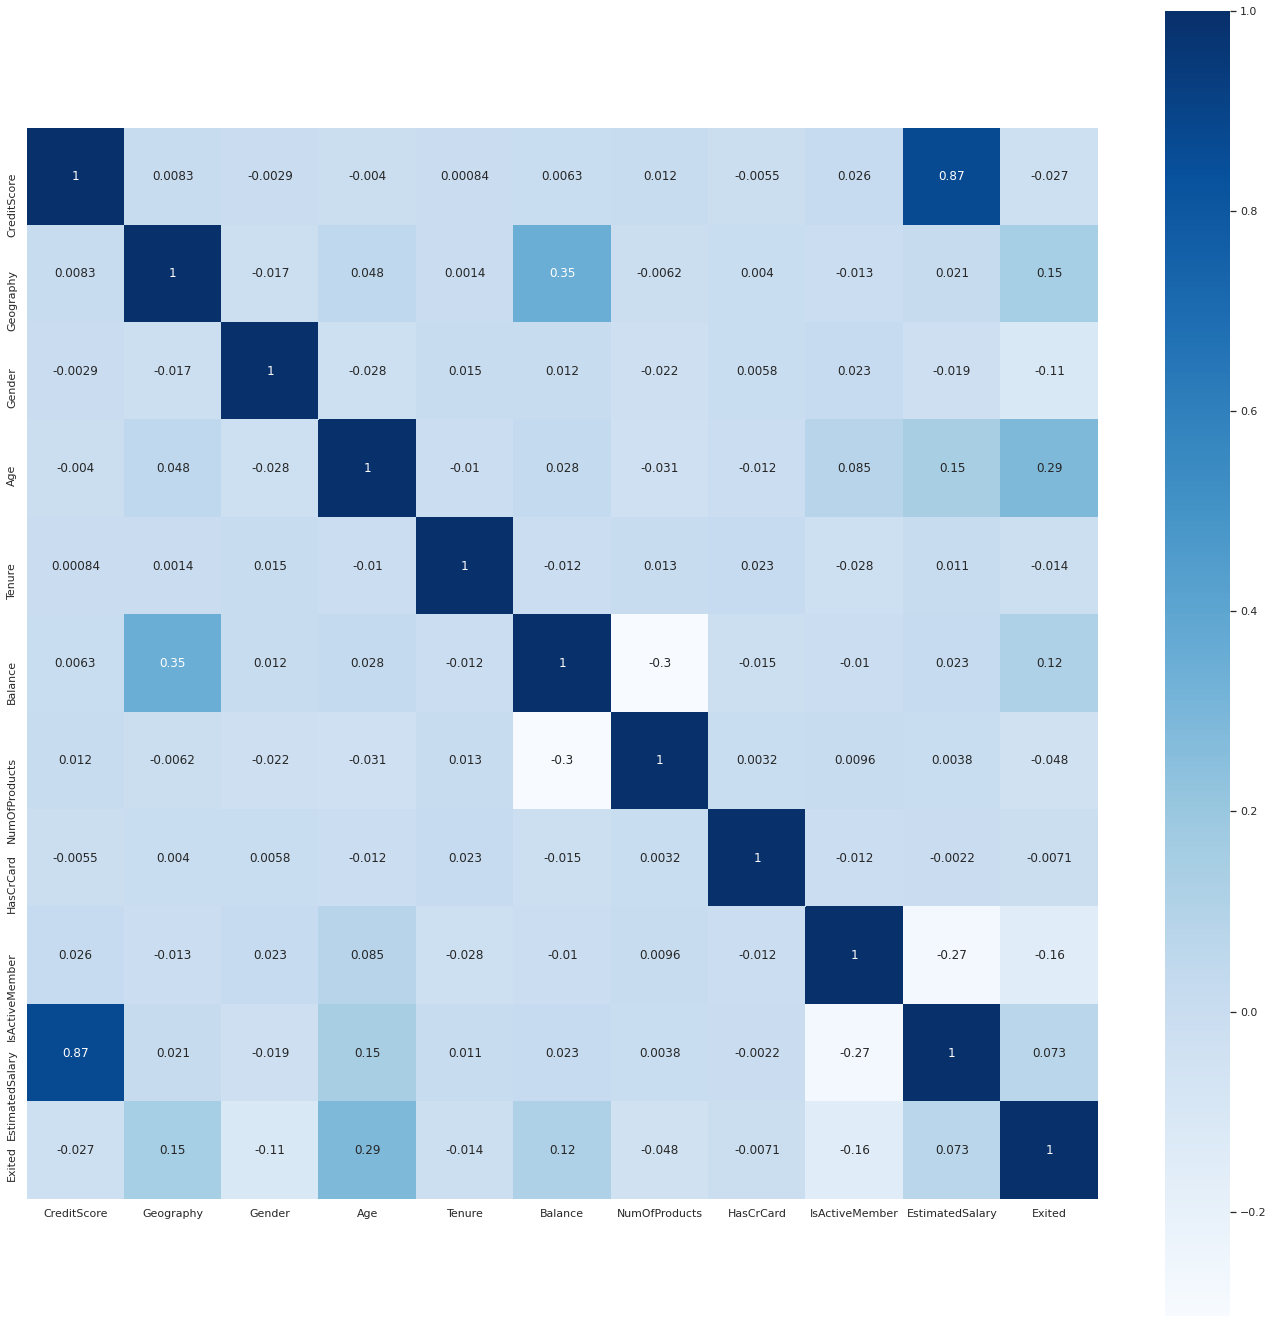

In [14]:
correlation = final_df.corr()

import matplotlib.pyplot as plt
fig = plt.subplots(figsize=(24,24))
sns.heatmap(correlation,vmax=1,square=True,annot=True,cmap='Blues')

### Strong correlation is between:

* estimated salary and credit score: **0.87** (it's **very strong** correlation!!!)
* geography and balance: **0.35**
* balance and number of products: **-0.3**
* exited and age: **0.29**
* estimated salary and is active member: **-0.27**

# Retention

### At first, I'm going to do analysis of retention, so I will check correlation with 'exited'.

The traits strongest correlated with 'exited' are:
    * Age (0.29)
    * IsActiveMember (-0.16)
    * Geography (0.15)
And possibly:
    * Balance (0.12)
    * Gender (-0.11)
    
Are there any correlations between them (each other)?
    * Balance & Geography (0.35) <---- I should pay attention to this creating model

## Models

Now it's a good moment to import necessery stuff :)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Data preparation (defining _X_ and _y_)
All the models that I decided to use in this project will use three variants of data:
* **no.1**: all variables
* **no.2**: variables stronger correlated with _**exited**_ (Age,IsActiveMember, Geography, Balance, Gender) - here we have correlation between _Balance_ and _Geography_
* **no.3**: variables the strongest correlated with _**exited**_ (Age,IsActiveMember, Geography)

In [16]:
# no.1
X_1 = final_df.drop('Exited', axis=1)
y_1 = final_df['Exited']

# no.2
X_2 = final_df[['Age','IsActiveMember', 'Geography', 'Balance', 'Gender']]
y_2 = final_df['Exited']

# no.3
X_3 = final_df[['Age','IsActiveMember', 'Geography']]
y_3 = final_df['Exited']

How these data looks like?

In [17]:
X_1.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,1,0,42,2,0.00,1,1,1,886607.90
1,608,2,0,41,1,83807.86,1,0,1,916554.56
2,502,1,0,42,8,159660.80,3,1,0,849781.25
3,699,1,0,39,1,0.00,2,0,0,1367384.50
4,850,2,0,43,2,125510.82,1,1,1,1504164.20


In [18]:
y_1.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [19]:
X_2.head()

,Age,IsActiveMember,Geography,Balance,Gender
0,42,1,1,0.00,0
1,41,1,2,83807.86,0
2,42,0,1,159660.80,0
3,39,0,1,0.00,0
4,43,1,2,125510.82,0


In [20]:
y_2.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [21]:
X_3.head()

,Age,IsActiveMember,Geography
0,42,1,1
1,41,1,2
2,42,0,1
3,39,0,1
4,43,1,2


In [22]:
y_3.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

As you can see, this is necessary to convert _y_ to DataFrame:

In [23]:
y_1 = pd.DataFrame(y_1)
y_2 = pd.DataFrame(y_2)
y_3 = pd.DataFrame(y_3)

How does it look now?

In [24]:
y_1.head()

,Exited
0,1
1,0
2,1
3,0
4,0


In [25]:
y_2.head()

,Exited
0,1
1,0
2,1
3,0
4,0


In [26]:
y_3.head()

,Exited
0,1
1,0
2,1
3,0
4,0


Much better :)

## Logistic Regression

What logistic regression is? Below there are few fragments found on the [TechTarget website](https://searchbusinessanalytics.techtarget.com/definition/logistic-regression).

>_"Logistic regression is a statistical analysis method used to predict a data value based on prior observations of a data set. (...) The approach allows an algorithm being used in a machine learning application to classify incoming data based on historical data. As more relevant data comes in, the algorithm should get better at predicting classifications within data sets. Logistic regression can also play a role in data preparation activities by allowing data sets to be put into specifically predefined buckets during the extract, transform, load (ETL) process in order to stage the information for analysis."_

>_"A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables."_

>_"Logistic regression is one of the most commonly used machine learning algorithms for binary classification problems, which are problems with two class values, including predictions such as “this or that,” “yes or no” and “A or B.” "_

>_"The purpose of logistic regression is to estimate the probabilities of events, including determining a relationship between features and the probabilities of particular outcomes."_

In our model we have binary classification: we should predict if client is going to exite (1) or not (0). 
So, first model which I want to check out is logistic regression :)

**what else is important when we are going to use logistic regression model?**

* only independent variables that have a significant impact on the dependent variable should be included in the model,
* independent variables must be independent of each other (uncorrelated),
* logistic regression requires large size of sample.

### Logistic regression parameters

According the scikit learn documentation, logistic regression model has following parameters: 

* **penalty** : {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
* **dual** : bool, default=False
* **tol** : float, default=1e-4
* **C** : float, default=1.0
* **fit_intercept** : bool, default=True
* **intercept_scaling** : float, default=1
* **class_weight** : dict or ‘balanced’, default=None
* **random_state** : int, RandomState instance, default=None
* **solver** : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
* **max_iter** : int, default=100
* **multi_class** : {‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’
* **verbose** : int, default=0
* **warm_start** : bool, default=False
* **n_jobs** : int, default=None
* **l1_ratio** : float, default=None

### Logistic Regression - all variables (no.1)

#### We already have prepared _X_ and _y_, so now I'm going to divide up all the examples into subsets: training set and testing set. 

**Training set** is the most important - this is what our model learns from. However, the size of this set should not be too large. In that case, our model can be **overtrained**. This means, that model can fit well with the training data, but applied to data not encountered during learning, will give worse results. In the picture below you can see how it works (green line).



**Testing set** is a separate set of data, that the model has not dealt with during learning. Thanks to it, we can test how our model works.

There could be also **validation set**, but this time I'll skip it. 

For the purposes of this project, I used the following proportions:
* **Training dataset = 0.8**
* **Test dataset = 0.2**

In [27]:
# Splitting arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42, stratify=y_1)

# Preparing training data for model
train = pd.concat([X_train, y_train], axis=1)
train_1 = train.loc[train['Exited'] == 1]
train = pd.concat([train, train_1, train_1, train_1])

X_train = train.drop('Exited', axis=1)
y_train = train['Exited']

# Below I decide which model I'm going to use and I train it using the above data. 
# For now, my model has default parameters.
logreg_model_no1 = LogisticRegression()
logreg_model_no1.fit(X_train,y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Now I'll check how accuracy looks:

In [28]:
logreg_model_no1.score(X_test, y_test)

0.591

Necessary is to predict the labels of the data values:

In [29]:
y_pred_logreg_no1 = logreg_model_no1.predict(X_test)

## Metrics

Logistic regression model is a classifier, so I evaluate it using the metrics designed to evaluate the classifiers:
* confusion matrix
* recall
* precision
* accuracy
* F1 score

#### How these metrics work? How to interpret their values?

### Confusion matrix

It is a special kind of contingency table, with two dimensions ("actual" and "predicted"), and identical sets of "classes" in both dimensions (each combination of dimension and class is a variable in the contingency table).

![alt text](http://mathspace.pl/wp-content/uploads/2015/10/ConfusionMatrix.png)

### Recall and Precision

These metrics are based on confusion matrix in the way described on the picture below (you can find it and read more on the [Wikipedia website](https://en.wikipedia.org/wiki/Precision_and_recall).

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)

![alt text](https://lawtomated.com/wp-content/uploads/2019/10/Recall_1-585x133.png)

![alt text](https://lawtomated.com/wp-content/uploads/2019/10/Precision_1-585x163.png)

### Accuracy

This metric we can also count using confusion matrix:
    
![alt text](https://lawtomated.com/wp-content/uploads/2019/10/Accuracy_1.png)

In oder words, we can describe it in this way:

![alt text](https://lawtomated.com/wp-content/uploads/2019/10/Accuracy_2-585x130.png)

### F1 Score

As we can read at [LaptrinhX Website](https://laptrinhx.com/accuracy-precision-recall-and-f1-scores-for-lawyers-3883682331/):

>_"The F1 Score is the weighted average (or harmonic mean) of Precision and Recall. Therefore, this score takes both False Positives and False Negatives into account to strike a balance between precision and Recall."_

![alt text](https://lawtomated.com/wp-content/uploads/2019/10/F1-Score-585x147.png)

In [30]:
print(classification_report(y_test,y_pred_logreg_no1))

              precision    recall  f1-score   support

           0       0.85      0.59      0.70      1593
           1       0.27      0.60      0.37       407

    accuracy                           0.59      2000
   macro avg       0.56      0.59      0.53      2000
weighted avg       0.73      0.59      0.63      2000



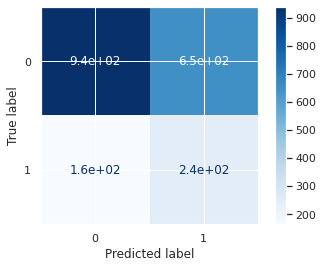

In [31]:
plot_confusion_matrix(logreg_model_no1, X_test, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues)

### Logistic Regression - variables stronger correlated with 'Exited'  (no.2)
Remember, that one pair of variables has correlation 0.35. I would like to show the impact of this correlation.

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X_2,y_2,test_size=0.2,random_state=42, stratify=y_2)

train=pd.concat([X_train, y_train], axis=1)
train_1=train.loc[train['Exited']==1]
train=pd.concat([train, train_1, train_1, train_1])

X_train=train.drop('Exited', axis=1)
y_train=train['Exited']

logreg_model_no2 = LogisticRegression()
logreg_model_no2.fit(X_train,y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
logreg_model_no2.score(X_test, y_test)

0.2035

In [34]:
y_pred_logreg_no2 = logreg_model_no2.predict(X_test)

In [35]:
print(classification_report(y_test,y_pred_logreg_no2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1593
           1       0.20      1.00      0.34       407

    accuracy                           0.20      2000
   macro avg       0.10      0.50      0.17      2000
weighted avg       0.04      0.20      0.07      2000



/home/katarzyna/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


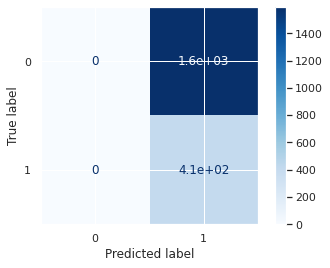

In [36]:
plot_confusion_matrix(logreg_model_no2, X_test, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues)

As we can see above, this model has very bad results. This I wanted to show using variables correlated with each other.

### Logistic Regression - variables the strongest correlated with 'Exited'  (no.3)

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X_3,y_3,test_size=0.3,random_state=42, stratify=y_3)

train=pd.concat([X_train, y_train], axis=1)
train_1=train.loc[train['Exited']==1]
train=pd.concat([train, train_1, train_1, train_1])

X_train=train.drop('Exited', axis=1)
y_train=train['Exited']

logreg_model_no3 = LogisticRegression()
logreg_model_no3.fit(X_train,y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
logreg_model_no3.score(X_test, y_test)

0.7156666666666667

In [39]:
y_pred_logreg_no3 = logreg_model_no3.predict(X_test)

In [40]:
print(classification_report(y_test,y_pred_logreg_no3))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      2389
           1       0.39      0.72      0.51       611

    accuracy                           0.72      3000
   macro avg       0.65      0.72      0.65      3000
weighted avg       0.80      0.72      0.74      3000



## Decision Tree

Simply description what decision tree is we can find at [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree):

>_A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements._

How it works we can see below :)

![alt text](https://i.imgur.com/1MD7ptT.png)

Using decision tree model we should remember that this model is sensitive to **overtraining**. The action which is necessery to prevent  overtraining is called **pruning**. We can do this by manipulating the model parameters, especially:
* _**criterion**_ (gini or entropy)
* _**max depth**_
* _**min and max leaf nodes**_

In [41]:
from sklearn.tree import DecisionTreeClassifier

## _To be continued..._ 